In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Data Wrangling
The dataset contains 918 entries with 11 features and a target variable (HeartDisease). The class distribution is relatively balanced, with a 55:45 ratio between heart disease and normal cases.

There were no missing values, but some data quality issues were addressed:

1) Cholesterol: A total of 175 entries had a value of 0, which is clinically implausible since a cholesterol level of 0 is incompatible with life and likely represents missing or incorrectly recorded data. To correct this, we replaced the 0 values with the median cholesterol value specific to each class (i.e., based on whether the patient had heart disease or not).

2) RestingBP: One entry had a resting blood pressure of 0, which is also medically invalid. This single row was dropped from the dataset.2

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.shape

(918, 12)

In [4]:
round(df['HeartDisease'].value_counts(normalize = True)*100, 2)

HeartDisease
1    55.34
0    44.66
Name: proportion, dtype: float64

In [5]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
for col in cat_cols:
    print(f'unique value in {col}: {df[col].unique()}')

unique value in Sex: ['M' 'F']
unique value in ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']
unique value in RestingECG: ['Normal' 'ST' 'LVH']
unique value in ExerciseAngina: ['N' 'Y']
unique value in ST_Slope: ['Up' 'Flat' 'Down']
unique value in FastingBS: [0 1]


In [7]:
# investigate unique values for quantitative features
df1 = df.copy()
df1 = df1.drop(cat_cols, axis = 'columns')

for col in df1.columns:
    print(f"unique values in {col}: {df1[col].unique()}")

unique values in Age: [40 49 37 48 54 39 45 58 42 38 43 60 36 44 53 52 51 56 41 32 65 35 59 50
 47 31 46 57 55 63 66 34 33 61 29 62 28 30 74 68 72 64 69 67 73 70 77 75
 76 71]
unique values in RestingBP: [140 160 130 138 150 120 110 136 115 100 124 113 125 145 112 132 118 170
 142 190 135 180 108 155 128 106  92 200 122  98 105 133  95  80 137 185
 165 126 152 116   0 144 154 134 104 139 131 141 178 146 158 123 102  96
 143 172 156 114 127 101 174  94 148 117 192 129 164]
unique values in Cholesterol: [289 180 283 214 195 339 237 208 207 284 211 164 204 234 273 196 201 248
 267 223 184 288 215 209 260 468 188 518 167 224 172 186 254 306 250 177
 227 230 294 264 259 175 318 216 340 233 205 245 194 270 213 365 342 253
 277 202 297 225 246 412 265 182 218 268 163 529 100 206 238 139 263 291
 229 307 210 329 147  85 269 275 179 392 466 129 241 255 276 282 338 160
 156 272 240 393 161 228 292 388 166 247 331 341 243 279 198 249 168 603
 159 190 185 290 212 231 222 235 320 187 266 287 404 31

## fixing 0 for cholesterol level

In [8]:
# choleasterol level shouldnt be 0, so we replace 0 for both majority and minority class with the median of majority and minority class when 
# cholesterol wasn't 0
df2 = df[df['Cholesterol'] == 0]
df21 = df2[df2['HeartDisease'] == 1]
df22 = df2[df2['HeartDisease'] == 0]
print(df21.shape)
print(df22.shape)

(152, 12)
(20, 12)


In [9]:
# filter out instances where cholesterol isnt 0 for both majority and minority class
df3 = df[df['Cholesterol'] != 0]
df31 = df3[df3['HeartDisease'] == 1]
df32 = df3[df3['HeartDisease'] == 0]

In [15]:
df21.loc[:,'Cholesterol'] = df21['Cholesterol'].replace(0, df31['Cholesterol'].median())
df22.loc[:,'Cholesterol'] = df22['Cholesterol'].replace(0, df32['Cholesterol'].median())

In [11]:
df4 = pd.concat([df21, df22, df31, df32], axis = 'rows')
df4.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,246.0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,246.0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,246.0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,246.0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,246.0,1,ST,131,Y,1.4,Up,1


## fixing 0 in resting BP

In [12]:
df5 = df4.copy()
df5 = df5.drop(df5[df5['RestingBP'] == 0].index, axis = 0)
df5.shape

(917, 12)

## Train test split

In [13]:
x = df5.drop(['HeartDisease'], axis ='columns')
y = df5['HeartDisease']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)

In [14]:
x_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
361,47,M,ASY,160,246.0,0,Normal,124,Y,0.0,Flat
604,68,M,NAP,134,254.0,1,Normal,151,Y,0.0,Up
659,59,M,NAP,126,218.0,1,Normal,134,N,2.2,Flat
793,67,M,ASY,125,254.0,1,Normal,163,N,0.2,Flat
352,56,M,ASY,120,246.0,0,ST,100,Y,-1.0,Down


# Feature Selection
To identify the most informative features for predicting heart disease, a series of feature importance and statistical relevance tests were conducted, including:

1) ANOVA F-test

2) Chi-squared test (Chi²)

3) Mutual Information

4) Correlation analysis

### 📌 Key Findings:
1) All features, except for RestingECG, were found to be statistically significant (P value < 0.05), indicating strong relationships with the target variable.

2) Correlation analysis revealed that no pair of numerical features exhibited high correlation, suggesting the absence of multicollinearity.

3) Mutual Information rankings confirmed that RestingECG contributed the least to model performance.

### ✅ Conclusion:
Based on these findings, RestingECG was dropped from the feature set to simplify the model without compromising predictive performance.



In [16]:
# encode categorical features
encoder = LabelEncoder()
for col in cat_cols:
    x_train[col] = encoder.fit_transform(x_train[col])
x_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
361,47,1,0,160,246.0,0,1,124,1,0.0,1
604,68,1,2,134,254.0,1,1,151,1,0.0,2
659,59,1,2,126,218.0,1,1,134,0,2.2,1
793,67,1,0,125,254.0,1,1,163,0,0.2,1
352,56,1,0,120,246.0,0,2,100,1,-1.0,0


## Chi Square test

In [17]:
f_value, p_value = chi2(x_train[cat_cols], y_train)
chi_df = pd.DataFrame({
    'F_value': f_value,
    'P_value': p_value
}, index = x_train[cat_cols].columns)

chi_df = chi_df.sort_values(by ='F_value', ascending =True)
chi_df

,F_value,P_value
RestingECG,0.860593,3.535729e-01
Sex,12.893514,3.297229e-04
FastingBS,46.877280,7.557376e-12
ST_Slope,61.588311,4.233242e-15
ExerciseAngina,104.749636,1.385855e-24
ChestPainType,120.521288,4.864200e-28


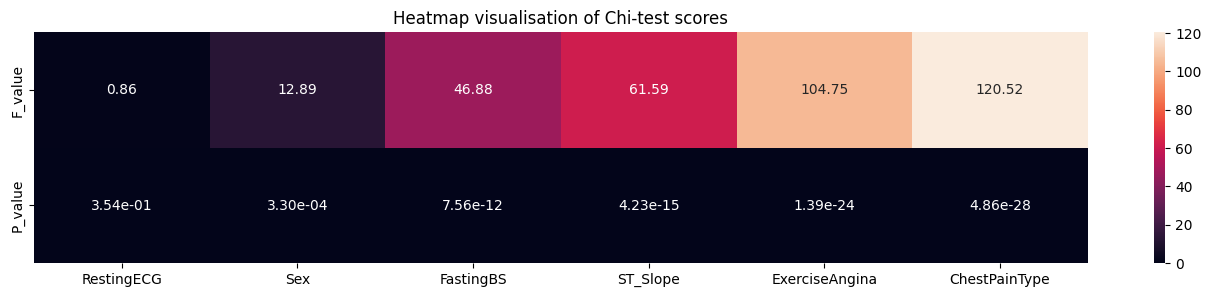

In [18]:
# format individual rows
annot = chi_df.copy()

annot['F_value'] = chi_df['F_value'].map(lambda x: f"{x:.2f}")
annot['P_value'] = chi_df['P_value'].map(lambda x: f"{x:.2e}") 

# heatmap plot
plt.figure(figsize = (17, 3))
sns.heatmap(chi_df.T, annot = annot.T.values, fmt = '')
plt.title('Heatmap visualisation of Chi-test scores')
plt.show()

## Anova test

In [19]:
x_anova = x_train.drop(cat_cols, axis = 'columns')

f_value, p_value = f_classif(x_anova, y_train)

anova_df = pd.DataFrame({
    'F_value': f_value,
    'P_value': p_value
}, index = x_anova.columns)

anova_df = anova_df.sort_values(by = 'F_value', ascending = True)
anova_df

,F_value,P_value
RestingBP,4.894676,2.724800e-02
Cholesterol,5.379245,2.065242e-02
Age,45.003254,3.941635e-11
Oldpeak,119.187574,8.261761e-26
MaxHR,125.389597,5.676235e-27


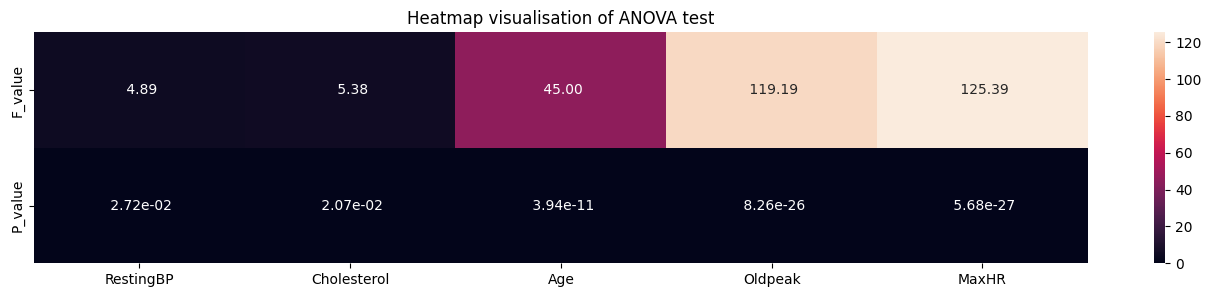

In [20]:
annot_anova = anova_df.copy()
annot_anova['F_value'] = annot_anova['F_value'].map(lambda x: f"{x: .2f}")
annot_anova['P_value'] =  annot_anova['P_value'].map(lambda x : f"{x: .2e}")


plt.figure(figsize = (17,3))
sns.heatmap(anova_df.T, annot = annot_anova.T.values, fmt = '')
plt.title('Heatmap visualisation of ANOVA test')

plt.show()


In [21]:
x_anova.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], dtype='object')

## Mutual Information

In [22]:
MI = mutual_info_classif(x_train, y_train)

mi_df = pd.DataFrame({
    'MI_values': MI
}, index = x_train.columns)

mi_df = mi_df.sort_values(by = 'MI_values', ascending = True)

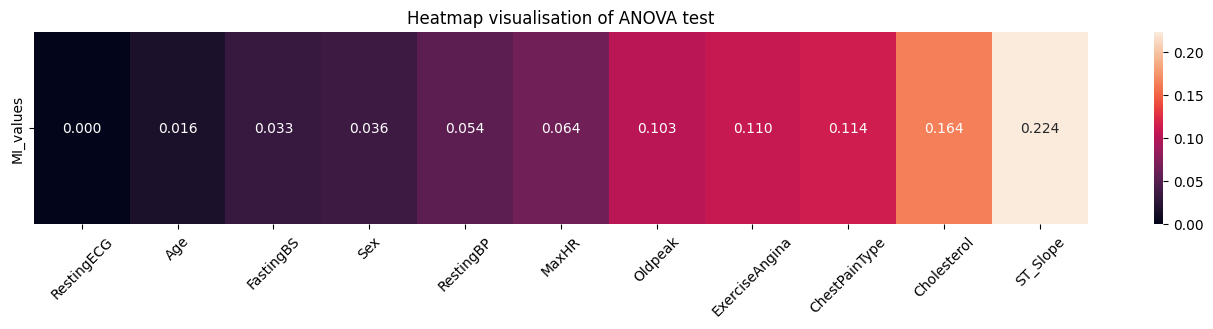

In [23]:
plt.figure(figsize = (17,2.5))
sns.heatmap(mi_df.T, annot = True, fmt = '.3f')
plt.title('Heatmap visualisation of ANOVA test')
plt.xticks(rotation= 45)

plt.show()

## Feature importance

In [24]:
tree_classif = ExtraTreesClassifier()
tree_classif.fit(x_train, y_train)

ExtraTreesClassifier()

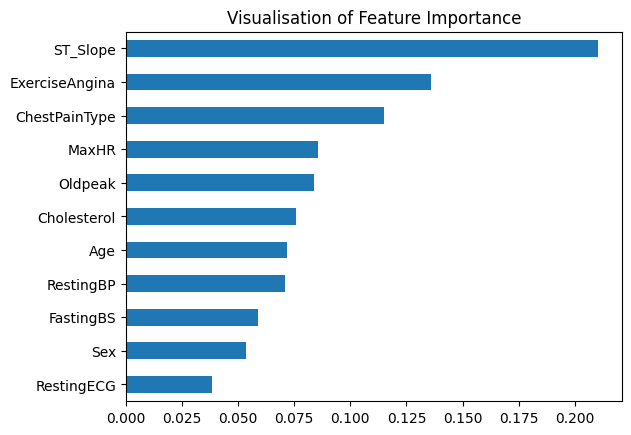

In [25]:
ranked_features = pd.Series(tree_classif.feature_importances_, index = x_train.columns).sort_values(ascending = True)
ranked_features.plot(kind = 'barh')

plt.title('Visualisation of Feature Importance')
plt.show()

## Correlation 

In [26]:
quant_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
corr_matrix = x_train[quant_features].corr()

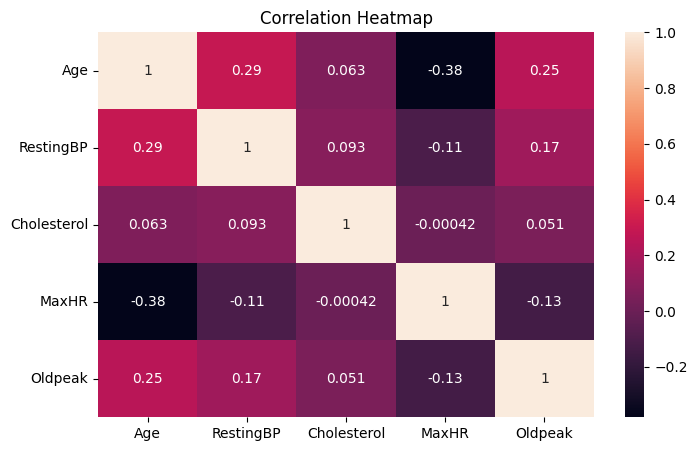

In [27]:
plt.figure(figsize = (8,5))
sns.heatmap(corr_matrix, annot = True)
plt.title('Correlation Heatmap')
plt.yticks(rotation = 360)
plt.show()

# Feature Engineering
As part of the feature engineering process:

1) Quantitative features in both the training and test datasets were scaled using MinMax Scaling to normalize values between 0 and 1.

2) Categorical features were encoded using Label Encoding to convert categorical labels into numeric form suitable for model input.

In [28]:
x_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
361,47,1,0,160,246.0,0,1,124,1,0.0,1
604,68,1,2,134,254.0,1,1,151,1,0.0,2
659,59,1,2,126,218.0,1,1,134,0,2.2,1
793,67,1,0,125,254.0,1,1,163,0,0.2,1
352,56,1,0,120,246.0,0,2,100,1,-1.0,0


In [33]:
scaler = MinMaxScaler()
for col in quant_features:
    x_train[col] = scaler.fit_transform(x_train[[col]])

x_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
361,0.387755,1,0,0.666667,0.310811,0,0.450704,1,0.295455,1
604,0.816327,1,2,0.450000,0.326255,1,0.640845,1,0.295455,2
659,0.632653,1,2,0.383333,0.256757,1,0.521127,0,0.545455,1
793,0.795918,1,0,0.375000,0.326255,1,0.725352,0,0.318182,1
352,0.571429,1,0,0.333333,0.310811,0,0.281690,1,0.181818,0


In [30]:
x_train = x_train.drop(['RestingECG'], axis ='columns')

## Engineer Test Dataset

In [34]:
x_test.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
645,57,M,NAP,128,229.0,0,LVH,150,N,0.4,Flat
771,55,M,ASY,140,217.0,0,Normal,111,Y,5.6,Down
416,63,M,ASY,140,260.0,0,ST,112,Y,3.0,Flat
736,54,M,ASY,122,286.0,0,LVH,116,Y,3.2,Flat
892,39,F,NAP,138,220.0,0,Normal,152,N,0.0,Flat


In [36]:
x_test = x_test.drop('RestingECG', axis = 'columns')

In [37]:
for col in quant_features:
    x_test[col] = scaler.transform(x_test[[col]])

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Age
Feature names seen at fit time, yet now missing:
- Oldpeak


In [38]:
for col in cat_cols:
    x_test[col] = encoder.fit_transform(x_test[col])

KeyError: 'RestingECG'

In [35]:
x_test.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
645,0.666667,1,2,0.28,0.300699,0,0.600000,0,0.071429,1
771,0.619048,1,0,0.40,0.272727,0,0.245455,1,1.000000,0
416,0.809524,1,0,0.40,0.372960,0,0.254545,1,0.535714,1
736,0.595238,1,0,0.22,0.433566,0,0.290909,1,0.571429,1
892,0.238095,0,2,0.38,0.279720,0,0.618182,0,0.000000,1


# Model Selection 
To identify the most promising models for heart disease prediction, we conducted cross-validation on four algorithms:

1) Random Forest

2) Logistic Regression

3) Support Vector Machine (SVM)

4) Decision Tree

The initial results showed that the Decision Tree model consistently underperformed compared to the others and was therefore excluded from further consideration.

The remaining models were then fine-tuned using hyperparameter optimization techniques to enhance performance. Among them, the Random Forest model with optimized parameters emerged as the most suitable for our problem, demonstrating strong predictive capability during initial evaluation.

## Cross_validation

In [36]:
round(np.mean(cross_val_score(LogisticRegression(), x_train, y_train, cv = 10, scoring ='f1', n_jobs = -1))*100,2)

np.float64(86.28)

In [37]:
round(np.mean(cross_val_score(DecisionTreeClassifier(), x_train, y_train, cv = 10, scoring ='f1', n_jobs = -1))*100,2)

np.float64(80.71)

In [38]:
round(np.mean(cross_val_score(RandomForestClassifier(), x_train, y_train, cv = 10, scoring ='f1', n_jobs = -1))*100,2)

np.float64(89.31)

In [39]:
round(np.mean(cross_val_score(SVC(), x_train, y_train, cv = 10, scoring ='f1', n_jobs = -1))*100,2)

np.float64(87.99)

## Hyper parameter tuning

In [40]:
param_grid = {
    'svc': {
        'modelname': SVC(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto'],
            'degree': [2, 3, 4]  # only relevant for 'poly' kernel
        }
    },

    'randomforest': {
        'modelname': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True, False]
        }
    },

    'logisticregression_saga_l1_l2': {
        'modelname': LogisticRegression(),
        'params': {
            'penalty': ['l1', 'l2'],
            'C': [0.01, 0.1, 1, 10],
            'solver': ['saga'],
            'max_iter': [500, 1000]
        }
    },

    'logisticregression_saga_elasticnet': {
        'modelname': LogisticRegression(),
        'params': {
            'penalty': ['elasticnet'],
            'C': [0.01, 0.1, 1, 10],
            'solver': ['saga'],
            'l1_ratio': [0.1, 0.5, 0.9],
            'max_iter': [500, 1000]
        }
    }
}

In [41]:
score = []

for model_name, mp in param_grid.items():
    clf = GridSearchCV(mp['modelname'], mp['params'], cv = 5, return_train_score = False)
    clf.fit(x_train, y_train)
    score.append({
    'model': model_name,
    'best_score': clf.best_score_,
    'best_params': clf.best_params_
    })
df = pd.DataFrame(score, columns = ['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svc,0.864915,"{'C': 0.1, 'degree': 4, 'gamma': 'scale', 'ker..."
1,randomforest,0.881269,"{'bootstrap': True, 'max_depth': None, 'max_fe..."
2,logisticregression_saga_l1_l2,0.848495,"{'C': 1, 'max_iter': 500, 'penalty': 'l2', 'so..."
3,logisticregression_saga_elasticnet,0.851235,"{'C': 1, 'l1_ratio': 0.1, 'max_iter': 500, 'pe..."


In [43]:
df_RF = df[df['model'] == 'randomforest']
df_RF['best_params'].iloc[0]

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

# Model Building
To build and evaluate robust predictive models, we experimented with five different strategies, each combining cross-validation with hyperparameter tuning and ensemble learning:

1) Grid Search + Stratified K-Fold Cross-Validation + Logistic Regression

2) Grid Search + Stratified K-Fold Cross-Validation + Random Forest

3) Grid Search + Stratified K-Fold Cross-Validation + Support Vector Machine (SVM)

4) Random Forest with manually fine-tuned hyperparameters

5) Voting Ensemble combining strategies 1 and 2

Outcome:
The five model-building strategies produced the following key results:

### Option 1: Logistic Regression (Grid Search + Stratified K-Fold)
Delivered the most balanced performance across all metrics, including precision, recall, and F1-score for both the majority and minority classes.

Accuracy: 88%

Precision: 87% (Class 0), 88% (Class 1)

### Option 2: Random Forest (Grid Search + Stratified K-Fold)
Achieved a high recall of 93% for the positive class (heart disease), which is crucial for medical applications, but with a slightly lower overall accuracy.

Accuracy: 86%

Recall (Class 1): 93%

### Options 3 & 4: SVM and Fine-tuned Random Forest
These models produced results comparable to Option 2, with high recall but lower overall accuracy.

Accuracy: 85%

Recall (Class 1): High (similar to Option 2)

### Option 5: Voting Ensemble (Logistic Regression + Random Forest)
Provided the best overall performance. It matched the accuracy of Option 1 while significantly improving recall for the positive class.

Accuracy: 88%

Recall (Class 1): 91%

Strong balance across all metrics

## ✅ Conclusion:
While Logistic Regression (Option 1) provided the most balanced base model, the voting ensemble (Option 5) achieved the best overall results, making it the most suitable choice for this heart disease prediction task—especially given the importance of maximizing recall in a healthcare context.


## Option 1: Logistic Regression/ stratified kFold/ Grid Search

In [44]:
# cross validation/ Logistic Regression
model1 = LogisticRegression()

cv = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

param_grid_1 = [
    {
        'penalty': ['l1'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear'],
        'class_weight': ['balanced'],
        'max_iter': [500, 1000]
    },
    {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced'],
        'max_iter': [500, 1000]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.5, 0.9],
        'class_weight': ['balanced'],
        'max_iter': [500, 1000]
    }
]


clf1 = GridSearchCV(model1, param_grid_1, cv = cv, n_jobs = -1, scoring = 'f1' )
clf1.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10], 'class_weight': ['balanced'],
                          'max_iter': [500, 1000], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10], 'class_weight': ['balanced'],
                          'max_iter': [500, 1000], 'penalty': ['l2'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.01, 0.1, 1, 10], 'class_weight': ['balanced'],
                          'l1_ratio': [0.1, 0.5, 0.9], 'max_iter': [500, 1000],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='f1')

In [45]:
y_predicted_1 = clf1.predict(x_test)
print(classification_report(y_test, y_predicted_1))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86        82
           1       0.89      0.88      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



## Option 2: Random Forest/ stratified kFold/ Grid Search

In [75]:
# random forest
model2 = RandomForestClassifier()

cv = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

param_grid_2 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'n_jobs': [-1]
}

clf2 = GridSearchCV(model2, param_grid_2, cv = cv, n_jobs = -1, scoring = 'f1' )
clf2.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200], 'n_jobs': [-1]},
             scoring='f1')

In [76]:
y_predicted_2 = clf2.predict(x_test)
print(classification_report(y_test, y_predicted_2))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83        82
           1       0.83      0.93      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.85      0.85       184
weighted avg       0.86      0.86      0.86       184



## Option 3: SVM/ stratified kFold/ Grid Search

In [59]:
# SVC
model3 = SVC()

cv = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

param_grid_3 = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

clf3 = GridSearchCV(model3, param_grid_3, cv = cv, n_jobs = -1 )
clf3.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']})

In [60]:
y_predicted_3 = clf3.predict(x_test)
print(classification_report(y_test, y_predicted_3))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81        82
           1       0.81      0.94      0.87       102

    accuracy                           0.85       184
   macro avg       0.86      0.84      0.84       184
weighted avg       0.86      0.85      0.85       184



## Option 4: Random Forest/ Finetuned Params

In [69]:
model4 = RandomForestClassifier(bootstrap =  True,
                                max_depth = None,
                                max_features = 'sqrt',
                                min_samples_leaf = 1,
                                min_samples_split = 2,
                                n_estimators = 100,
                                random_state = 42)
model4.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [70]:
y_predicted_4 = model4.predict(x_test)
print(classification_report(y_test, y_predicted_4))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82        82
           1       0.83      0.93      0.88       102

    accuracy                           0.85       184
   macro avg       0.86      0.84      0.85       184
weighted avg       0.86      0.85      0.85       184



## Option 5:  Voting ensemble between option 1 and option 2

In [71]:
Voting_classif = VotingClassifier(
    estimators = [
        ('rf', clf2.best_estimator_),
        ('logreg', clf1.best_estimator_)
    ],
    voting = 'soft',
    n_jobs = -1
)

Voting_classif.fit(x_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=20,
                                                     min_samples_leaf=2)),
                             ('logreg',
                              LogisticRegression(C=10, class_weight='balanced',
                                                 max_iter=500,
                                                 solver='liblinear'))],
                 n_jobs=-1, voting='soft')

In [72]:
y_predicted_voting = Voting_classif.predict(x_test)
print(classification_report(y_test, y_predicted_voting))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        82
           1       0.88      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



# Model Evaluation
The ensemble model shows high classification ability with a high AUC of 0.93 and a recall of 91%, making it highly suitable for early heart failure detection where missing true positives could be fatal.

In [77]:
Voting_classif = VotingClassifier(
    estimators = [
        ('rf', clf2.best_estimator_),
        ('logreg', clf1.best_estimator_)
    ],
    voting = 'soft',
    n_jobs = -1
)

Voting_classif.fit(x_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=20,
                                                     min_samples_split=10,
                                                     n_jobs=-1)),
                             ('logreg',
                              LogisticRegression(C=10, class_weight='balanced',
                                                 max_iter=500,
                                                 solver='liblinear'))],
                 n_jobs=-1, voting='soft')

## Confusion Matrix

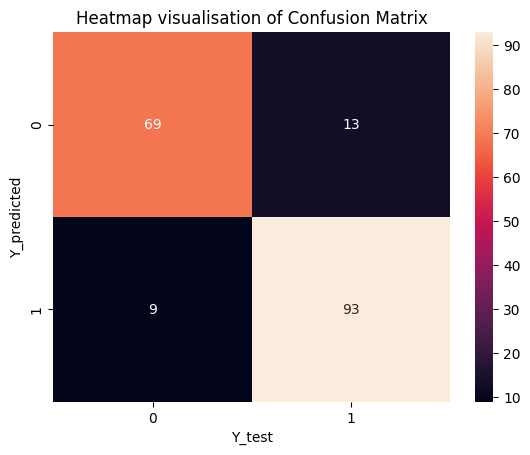

In [80]:
y_predicted_voting = Voting_classif.predict(x_test)

cm = confusion_matrix(y_test, y_predicted_voting)
sns.heatmap(cm, annot = True)
plt.title('Heatmap visualisation of Confusion Matrix')
plt.xlabel('y_test')
plt.ylabel('Y_predicted')
plt.show()

In [87]:
print(classification_report(y_test, y_predicted_voting))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        82
           1       0.88      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



## ROC_AUC Score

In [85]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_proba = Voting_classif.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9308


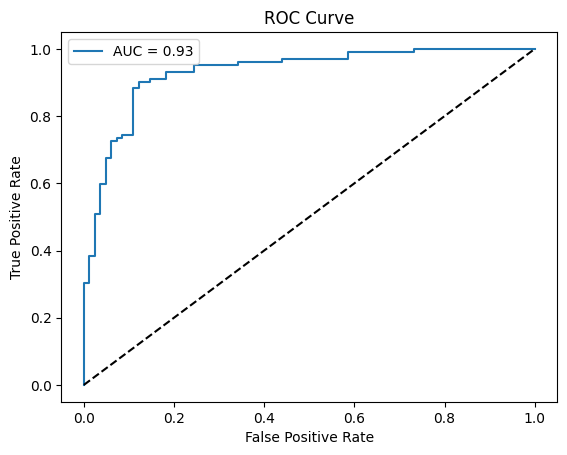

In [86]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()